In [1]:
import os
import pandas as pd
import numpy as np
import cv2 as cv
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# create a dictionary to hold the image data along with creating the corresponding labels
animals = ['ChickenHead', 'BearHead', 'ElephantHead','EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead']
data = dict()
data['fileName'] = []
data['content'] = []
data['label'] = []
for subdir in animals:
    #print(subdir[:-4])
    currPath ='image/'+subdir
    for file in os.listdir(currPath):
        #print(file)
        filePath = currPath + '/'+file # setting the image reading path
        image = cv.imread(filePath) # reading the image
        imageGray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # converting the image to grayscale
        imageGrayResize = cv.resize(imageGray, (80,80), interpolation = cv.INTER_AREA) # resizing the image
        data['fileName'].append(file)
        data['content'].append(imageGrayResize)
        data['label'].append(subdir[:-4])
        
# saving the image data dictionary in a pickle file
with open('dataImage.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# loading the pickle file to get the dataset dictionary
with open('dataImage.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

# train-test split the dataset
xData = np.array(dataset['content'])
yLabels = np.array(dataset['label'])
xTrain, xTest, yTrain, yTest = train_test_split(xData, yLabels, test_size=0.2, shuffle=True, random_state=42) 

In [4]:
# using the hog transform the given reference as it is required to use a transformer for pipelining and optimizing the model

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [5]:
# create an instance of hog transformer
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
# create an instance of standardscaler transformer
scalify = StandardScaler()
 
# call fit_transform on each transform converting xTrain
xTrainHog = hogify.fit_transform(xTrain)
xTrainPrepared = scalify.fit_transform(xTrainHog)

In [6]:
# create a pipeline for the classifier

HOGPipeline = Pipeline([
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])


# cross validation and optimization using gridsearchcv

# create the gridsearch parameters 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

# using 5 folds for the cross validation
gridSearch = GridSearchCV(HOGPipeline, param_grid, cv=5,n_jobs=-1, scoring='accuracy',verbose=1, return_train_score=True)
# fitting gridsearch with training data
gridRes = gridSearch.fit(xTrain, yTrain)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.5min finished
/Users/rysul/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [7]:
print('Best parameters obtained from the grid search: {}'.format(gridRes.best_params_))
print('Best score obtained from the grid search: {}'.format(gridRes.best_score_))

Best parameters obtained from the grid search: {'classify': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'hogify__cells_per_block': (2, 2), 'hogify__orientations': 8, 'hogify__pixels_per_cell': (8, 8)}
Best score obtained from the grid search: 0.92573402417962


In [8]:
# saving the fitted model in a pickle
with open('svcModel.pickle', 'wb') as handle:
    pickle.dump(gridRes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# loading the saved model
with open('svcModel.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [10]:
# getting the predictions on the testing data
bestPred = model.predict(xTest)
print('Accuracy on the training data: ', 100*np.sum(bestPred == yTest)/len(yTest))

Accuracy on the training data:  88.96551724137932


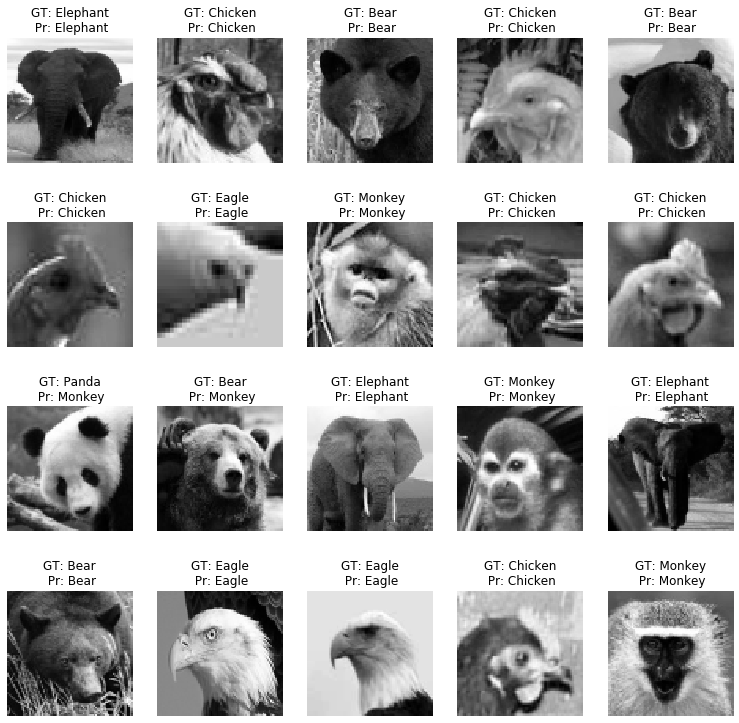

In [11]:
# displaying 20 actual images with the Ground Truths (GT) and Predictions (Pr) as image title 
# creating a list of not repeating random numbers
numberofImages = 20
indices = random.sample(range(xTest.shape[0]), numberofImages)
fig = plt.figure(figsize=(13, 13))
columns = 5
rows = np.ceil(numberofImages/columns)

# ax enables access to manipulate each of subplots
ax = []

for i, index in enumerate(indices):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('GT: '+ yTest[index]+ '\n Pr: '+bestPred[index])  # set title
    plt.imshow(xTest[index],cmap = plt.cm.gray)
    plt.axis('off')

Text(0.5, 1.0, 'Predicted: Panda')

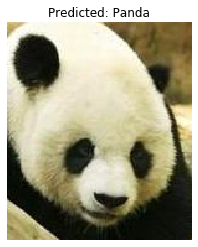

In [12]:
# input one image and classify it
# greyify
# resize
image = cv.imread('20080310_panda.jpg')
imageGray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # converting the image to grayscale
imageGrayResize = cv.resize(imageGray, (80,80), interpolation = cv.INTER_AREA) # resizing the image
# then model.predict
yPred = model.predict(imageGrayResize.reshape((1, 80, 80))) # have to reshape in 3D
# display
imageRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(imageRGB)
plt.axis('off')
plt.title('Predicted: '+yPred[0])